In [108]:
import arviz
import pyro
import torch
import numpy as np
import pyro.contrib.gp as gp
import pyro.distributions as dist
import matplotlib.pyplot as plt
from torch.distributions import constraints
from scipy.stats import multivariate_normal

In [109]:
# The function
g = lambda x: (-(np.sin(6*torch.pi*x))**2) + 6*(x**2) - 5*(x**4) + (3/2)

In [110]:
torch.manual_seed(42)
np.random.seed(42)

In [111]:
X_train = torch.linspace(0, 1, 101)
y_train = g(X_train) +np.random.normal(scale = 0.01, size = (101,))

In [112]:
def gen_model(priors = True, period = torch.tensor(1.), lengthPer = torch.tensor(1.), 
              lengthRBF = torch.tensor(1.), varPer = torch.tensor(1.), varRBF= torch.tensor(1.)):
    
    # defining kernels
    periodic = gp.kernels.Periodic(input_dim=1, period=period, lengthscale=lengthPer, variance=varPer)
    rbf = gp.kernels.RBF(input_dim=1, lengthscale=lengthRBF, variance=varRBF)
    k = gp.kernels.Sum(kern0=rbf, kern1=periodic)

    model = gp.models.GPRegression(
        X=X_train,
        y=y_train,
        kernel=k,
        noise= torch.tensor(0.1),
    )
    if priors == True: 
        # RBF Kernel               
        model.kernel.kern0.variance_unconstrained.detach_()
        model.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.5))
        # Periodic Kernel
        model.kernel.kern1.variance_unconstrained.detach_()
        model.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-1, 0.5))
        model.kernel.kern1.period = pyro.nn.PyroSample(dist.LogNormal(-1, 0.5))
            
    return model

In [113]:
# We use one MAP estimates from the B.1 
model = gen_model(False, 
                  period=torch.tensor(0.3333980143070221),
                  lengthPer=torch.tensor(1.4498924016952515),
                  lengthRBF=torch.tensor(0.32564881443977356),
                  varPer=torch.tensor(1.0),
                  varRBF=torch.tensor(1.0)
                  )

In [114]:
def sample_f_given_X_q(n, kernel, l, q):
    x = torch.linspace(0, 1, l)
    w = torch.full((l,),  1/(l - 1))
    w[0] = w[l - 1] = 1 / (2*l - 2)
    A = torch.concat((w.reshape(1, -1), torch.eye(l)))
    cov_f = kernel(x)
    if (torch.linalg.eigh(cov_f + 1e-5 * torch.eye(l))[0] < 0).any():
        print("Cov not psd")
    cov_q_f = A @ cov_f @ A.T
    cov_qq = cov_q_f[0, 0]
    cov_qf = cov_q_f[0, 1:].reshape(1, -1)
    cov_fq = cov_q_f[1:, 0].reshape(-1, 1)
    cov_ff = cov_q_f[1:, 1:]
    mean_f_given_X_q = cov_fq / cov_qq * q 
    cov_f_given_X_q = cov_ff - 1 / cov_qq * cov_fq  @ cov_fq.T + 1e-5 * torch.eye(l)
    if (torch.linalg.eigh(cov_f_given_X_q)[0] < 0).any():
        print("Cov f given X and q not psd")
    return (np.random.multivariate_normal(mean_f_given_X_q.reshape(-1), 
                                         cov_f_given_X_q, size=n, check_valid='ignore'),
            np.random.multivariate_normal(np.zeros(cov_f.shape[0]), cov_f + 1e-5 * torch.eye(l), size = n, check_valid="ignore"))



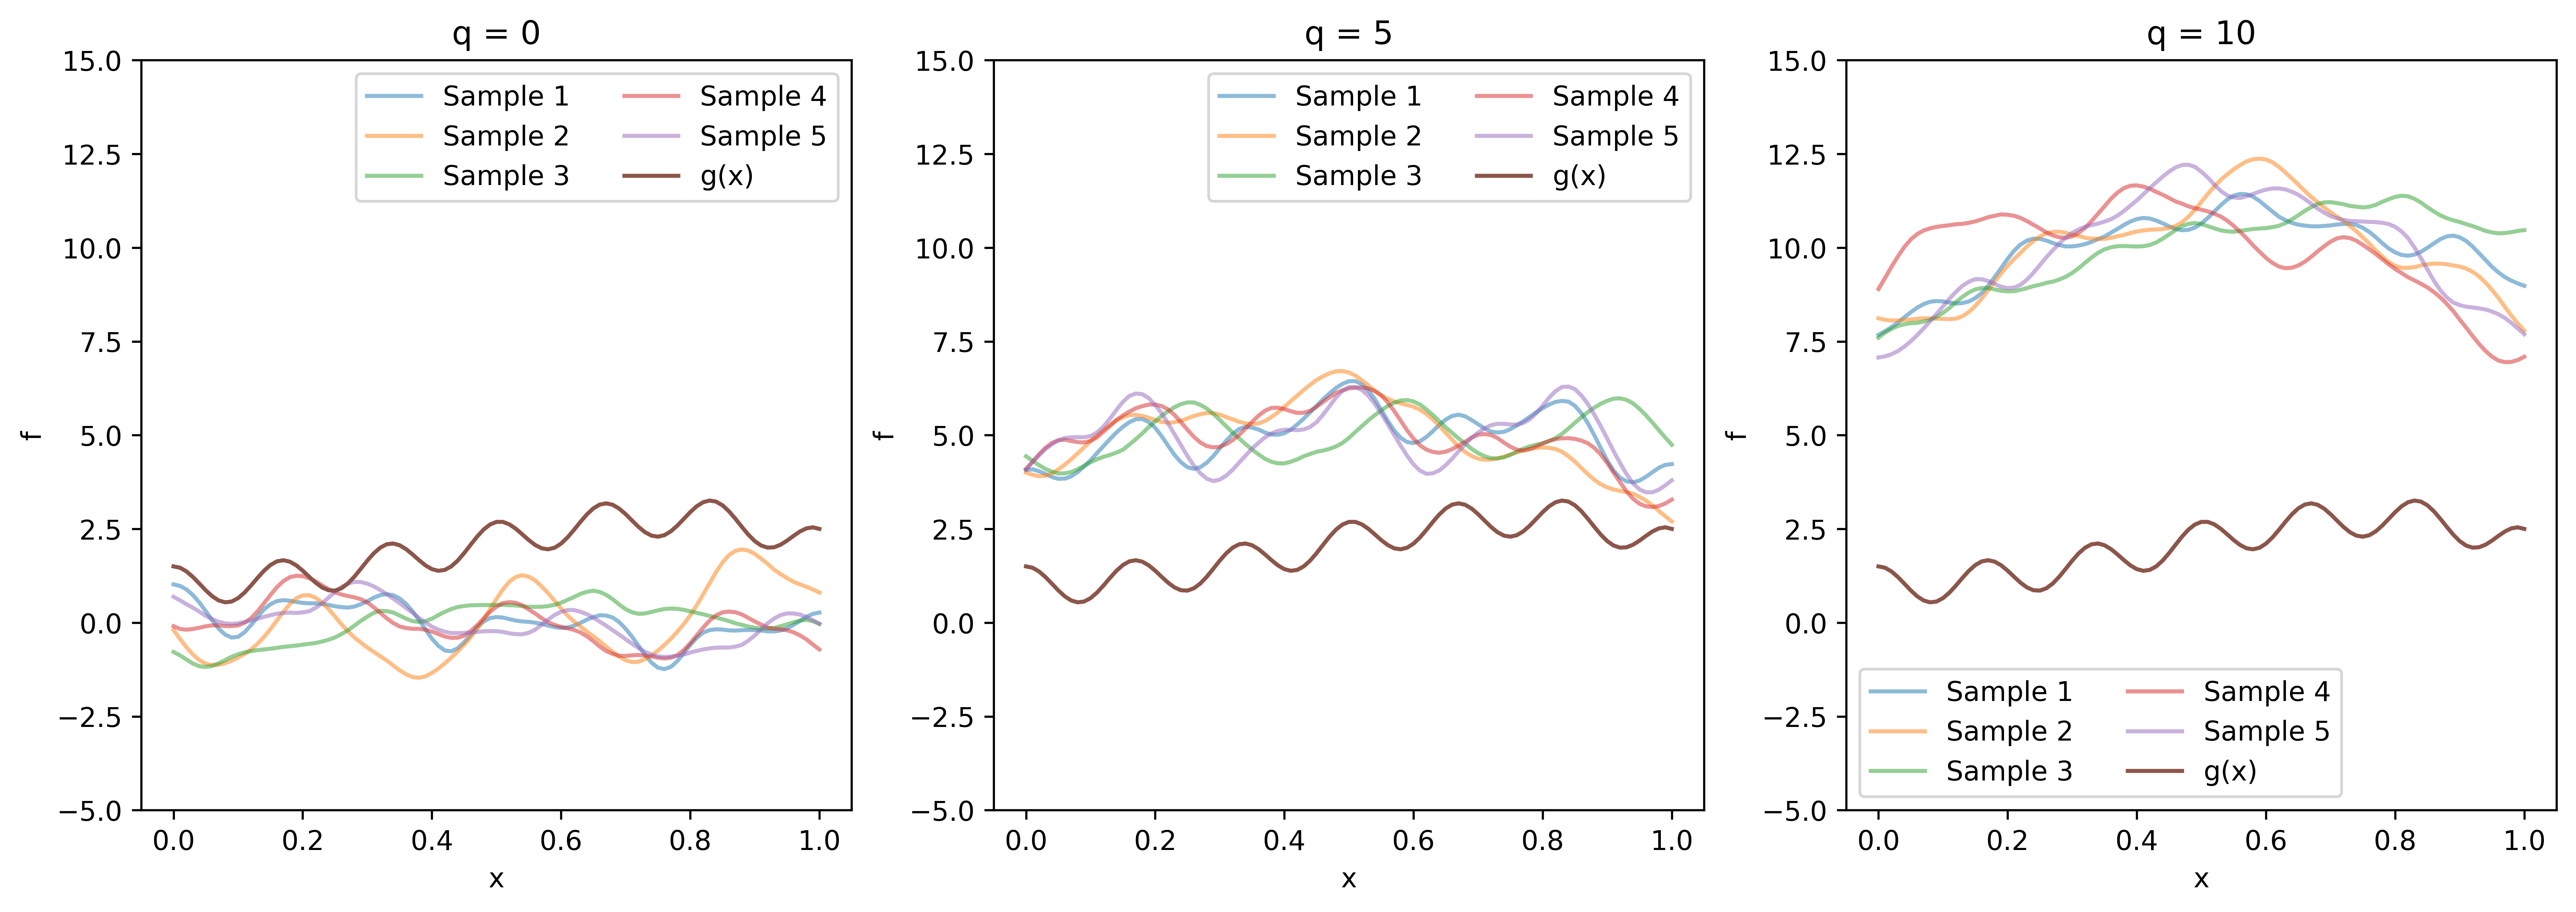

In [115]:
fig, axs = plt.subplots(1,3, figsize = (16, 5), dpi = 600)
qs = [0, 5, 10]
x = np.linspace(0, 1, 101)
for q, axs in zip(qs, axs):
    with torch.no_grad():
        samples = sample_f_given_X_q(5, model.kernel, l=101, q=q)
    for i, (sample_q, _) in enumerate(zip(*samples)):
        axs.plot(x, sample_q, alpha = 0.5, label = f"Sample {i + 1}")
    axs.plot(x, g(x), label = "g(x)")
    axs.set_xlabel("x")
    axs.set_ylabel("f")
    axs.set_title(f"q = {q}")
    axs.legend(ncols = 2)
    axs.set_ylim(-5, 15)
plt.savefig("samples_f_given_q_X.png")
plt.show()


In [140]:
def get_posterior(kernel, x, y, noise, l, q):
    x_test = torch.linspace(0, 1, l)
    w = torch.full((l,),  1/(l - 1))
    w[0] = w[l - 1] = 1 / (2*l - 2)
    A = torch.concat((w.reshape(1, -1), torch.eye(l)))
    k_Sx = kernel(x, x_test)
    k_S = kernel(x)
    k_x = kernel(x_test)
    inverse = torch.linalg.inv(k_S + noise * torch.eye(x.shape[0]))
    mean_f = k_Sx.T @ inverse @ y
    cov_f = k_x - k_Sx.T @ inverse @ k_Sx
    mean_q = torch.dot(w, mean_f)

    if (torch.linalg.eigh(cov_f + 1e-5 * torch.eye(l))[0] < 0).any():
        print("Cov not psd")
    cov_q_f = A @ cov_f @ A.T
    cov_qq = cov_q_f[0, 0]
    cov_qf = cov_q_f[0, 1:].reshape(1, -1)
    cov_fq = cov_q_f[1:, 0].reshape(-1, 1)
    cov_ff = cov_q_f[1:, 1:]
    mean_f_given_X_q = mean_f + (cov_fq / cov_qq * (q - mean_q)).reshape(-1)
    cov_f_given_X_q = cov_ff - 1 / cov_qq * cov_fq  @ cov_fq.T + 1e-5 * torch.eye(l)
    if (torch.linalg.eigh(cov_f_given_X_q)[0] < 0).any():
        print("Cov f given X and q not psd")
    return (
        mean_f.numpy(), 
        1.95 * torch.sqrt(torch.diag(cov_f)).numpy(), 
        mean_f_given_X_q.numpy(),
        1.95 * torch.sqrt(torch.diag(cov_f_given_X_q)).numpy()
    )

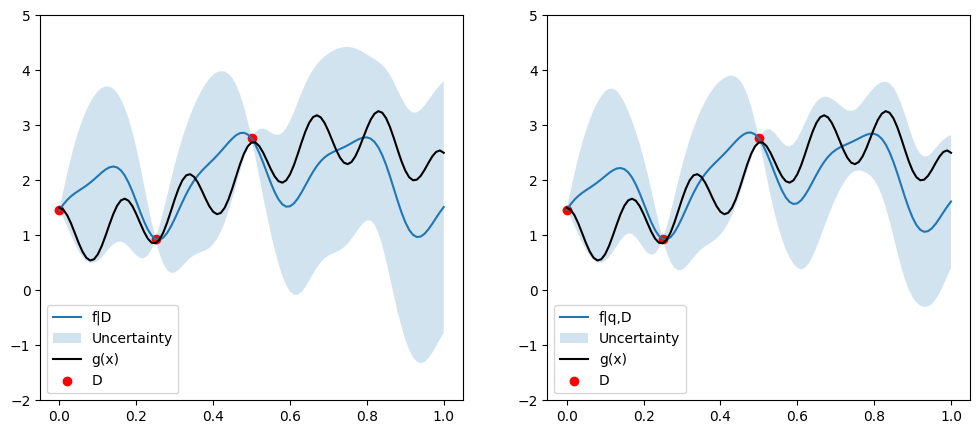

In [163]:
Dx = torch.tensor([0, 0.25, 0.5])
Dy = torch.tensor([1.46, 0.93, 2.76])
with torch.no_grad():
    m_f, v_f, m_f_q, v_f_q = get_posterior(model.kernel, 
                                noise = torch.tensor(0.0001266094477614388),
                                x = Dx, 
                                y = Dy,
                                l=101, q=2)

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].plot(x, m_f, label = "f|D")
axs[0].fill_between(x, m_f + v_f, m_f - v_f, alpha = 0.2, label = "Uncertainty")
axs[1].plot(x, m_f_q, label = "f|q,D")
axs[1].fill_between(x, m_f_q + v_f_q, m_f_q - v_f_q, alpha = 0.2,  label = "Uncertainty")

for ax in axs:
    ax.set_ylim(-2, 5)
    ax.plot(x, g(x), label = "g(x)", color = "black")
    ax.scatter(Dx, Dy, label = "Dataset", color ="red")
    ax.legend(loc = "lower left")

